# Esercizi di programmazione

## Esercizio 1: Anagrammi
Vogliamo realizzare una macchina che generi anagrammi a partire da parole reali. Il gioco consiste nel ricostruire la parola corretta a partire dalle lettere ricombinate fra loro.

Concepire sia la macchina per la creazione dell'anagramma casuale da risolvere, sia la macchina che gioca, cercando di indovinare il testo originale.

### Ingredienti
- ???

### Procedura
- ???

**Risorse utili**
Possiamo utilizzare una lista di parole estratte da un testo.

In [12]:
import json
import numpy as np
import random 
import nltk 

In [3]:
jfile = "./data/parole_manzoni.json"
with open(jfile, 'r') as infile:
    data = json.load(infile)
words = data['words']
print(words[:10])

['ramo', 'lago', 'esce', 'giace', 'catene', 'interrotte', 'monti', 'settentrione', 'mezzogiorno', 'dopo']


In [81]:
class Controller:
    def __init__(self, words):
        self.words = words 
        self.minlen, self.maxlen = self.check_len()

    def check_len(self):
        minlen = None
        maxlen = None
        for word in self.words:
            if minlen is None:
                minlen = len(word)
            if maxlen is None:
                maxlen = len(word)
            if len(word) < minlen:
                minlen = len(word)
            if len(word) > maxlen:
                maxlen = len(word)
        return minlen, maxlen

    def select_word(self, num_chars):
        if self.minlen <= num_chars <= self.maxlen:
            selected_words = []
            for word in self.words:
                if len(word) == num_chars:
                    selected_words.append(word)
            w = np.random.choice(selected_words)
            return w
        else:
            return np.random.choice(self.words)

    def split_word(self, word):
        return list(word)

    def shuffle(self, list_chars):
        random.shuffle(list_chars)
        return list_chars

class DummyPlayer:
    def __init__(self, chars, words):
        self.chars = chars
        self.words = words
    def play(self):
        ch = [x for x in self.chars]
        random.shuffle(ch)
        return "".join(ch)
    
class SmartPlayer(DummyPlayer):
    def __init__(self, chars, words):
        super().__init__(chars, words)
        self.unigram = {}
        self.bigram = {}
        self.indexing()
        self.U = sum(self.unigram.values())
        self.B = sum(self.bigram.values())
        
    def p_unigram(self, c):
        try:
            p = self.unigram[c] / self.U
        except KeyError:
            p = 1 / self.U
        return p
    
    def p_bigram(self, x, y):
        try:
            p = self.bigram[(x, y)] / self.B
        except KeyError:
            p = 1 / self.B
        return p
    
    def pickup_letter(self):
        list_of_p = []
        for c in self.chars:
            if c in self.unigram.keys():
                list_of_p.append(self.unigram[c])
            else:
                list_of_p.append(1)
        list_of_p = np.array(list_of_p) / sum(list_of_p)
        return np.random.choice(self.chars, size=len(self.chars), p=list_of_p, replace=False)
    
    def pickup(self, chars, previous=None):
        list_of_p = []
        for c in chars:
            if previous is None:
                if c in self.unigram.keys():
                    list_of_p.append(self.unigram[c])
                else:
                    list_of_p.append(1)
            else:
                pair = (previous, c)
                if pair in self.bigram.keys():
                    list_of_p.append(self.bigram[pair])
                else:
                    list_of_p.append(1)
        list_of_p = np.array(list_of_p) / sum(list_of_p)
        return np.random.choice(chars, p=list_of_p)
    
    def play(self):
        word = []
        chars = [x for x in self.chars]
        while len(word) < len(self.chars):
            if len(word) > 0:
                previous = word[-1]
            else:
                previous = None
            next_char = self.pickup(chars=chars, previous=previous)
            word.append(next_char)
            i = chars.index(next_char)
            del(chars[i])
        return "".join(word)

    def indexing(self):
        for word in self.words:
            for a, b in nltk.ngrams(word, n=2):
                if a in self.unigram.keys():
                    self.unigram[a] += 1
                else:
                    self.unigram[a] = 1
                if b in self.unigram.keys():
                    self.unigram[b] += 1
                else:
                    self.unigram[b] = 1
                if (a, b) in self.bigram.keys():
                    self.bigram[(a, b)] += 1
                else:
                    self.bigram[(a, b)] = 1

In [82]:
sp = SmartPlayer(list('verde'), words=words)

In [87]:
print(sp.chars)
print(sp.play())

['v', 'e', 'r', 'd', 'e']
vrede


In [25]:
print(sp.p_unigram('a'))
print(sp.p_unigram('z'))

0.10619051512673754
0.011492232215862633


In [88]:
c = Controller(words=words)
trials_dummy = []
trials_smart = []
for match in range(100):
    w = c.select_word(num_chars=6)
    l = c.split_word(w)
    s = c.shuffle(l)
    dummy = DummyPlayer(chars=s, words=c.words)
    smart = SmartPlayer(chars=s, words=c.words)
    counter_dummy = 0
    for i in range(5000):
        counter_dummy += 1
        guess_dummy = dummy.play()
        if guess_dummy == w:
            break
    trials_dummy.append(counter_dummy)
    counter_smart = 0
    for i in range(5000):
        counter_smart += 1
        guess_smart = smart.play()
        if guess_smart == w:
            break
    trials_smart.append(counter_smart)

In [89]:
td = np.array(trials_dummy)
ts = np.array(trials_smart)
print(f"Media: {td.mean()}")
print(f"Std: {td.std()}")

print(f"Media: {ts.mean()}")
print(f"Std: {ts.std()}")


Media: 335.61
Std: 367.4373115240204
Media: 666.16
Std: 1282.410205199569


### Visualizzazione

In [90]:
import matplotlib.pyplot as plt

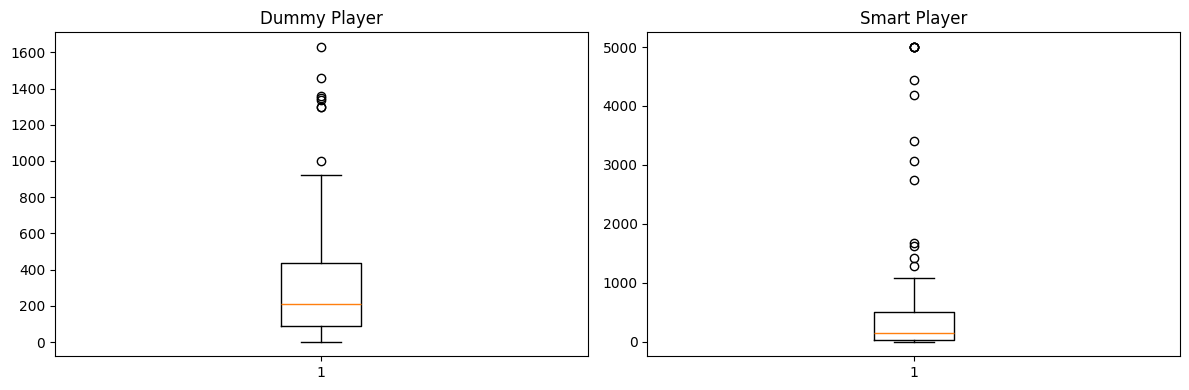

In [91]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=2)
ax[0].boxplot(td)
ax[0].set_title("Dummy Player")
ax[1].boxplot(ts)
ax[1].set_title("Smart Player")
plt.tight_layout()
plt.show()

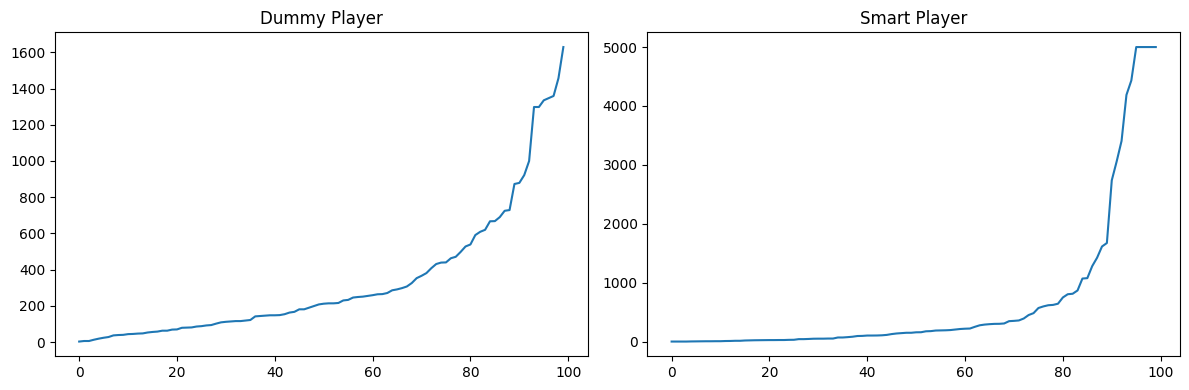

In [92]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=2)
d = sorted(td)
s = sorted(ts)
ax[0].plot(d)
ax[0].set_title("Dummy Player")
ax[1].plot(s)
ax[1].set_title("Smart Player")
plt.tight_layout()
plt.show()

In [ ]:
nltk.ngrams("mario", n=2)print(list())

[('m', 'a'), ('a', 'r'), ('r', 'i'), ('i', 'o')]
